# Crop Field Siamese with Triplet Loss with Graph-based segmentation

The goal is to evaluate the algorithm using time series of the same h3 hex.

## Summary
[1. Data Processing](#data_processing)

[2. Model Training](#model_training)

[3. Graph Based Segmenation](#graphbased_segmentation)

## Load required libraries

In [1]:
import sys

# Install packages required only once
install_packages = False

if install_packages:
    !{sys.executable} -m pip install sklearn
    !{sys.executable} -m pip install seaborn

In [2]:
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import seaborn.objects as so
import seaborn as sns

import pandas as pd
import numpy as np

import folium
import h3

## Hyper-parameters and other constants

In [3]:
temporal_samples = 15
band_features = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

width = 60 # output vector size
temperature = 0.1 # empirical temperature value

steps_per_epoch = 10
AUTOTUNE = tf.data.AUTOTUNE
shuffle_buffer = 5
num_epochs = 20

queue_size = 10000

<a id='data_processing'></a>

# 1. Data Processing

<div>
<img border="5px" src="../res/dataprocessing.png" width="1000"/>
</div>

## Configure the train and test datasets

In [4]:
from pathlib import Path

positive_samples_folder = Path('D:\\173_seeding_harvest_joined_USCA_mini.parquet\\positive_samples\\hex_index_L3=8348b3fffffffff')
negative_samples_folder = Path('D:\\173_seeding_harvest_joined_USCA_mini.parquet\\negative_samples\\hex_index_L3=8348b3fffffffff')

## Load all parquet files from the configured folder

In [5]:
df_positive = pd.concat(
            pd.read_parquet(parquet_file)
            for parquet_file in positive_samples_folder.rglob('*.parquet')
         )

df_negative = pd.concat(
            pd.read_parquet(parquet_file)
            for parquet_file in negative_samples_folder.rglob('*.parquet'))

print('The shape of loaded positive dataframe is:', df_positive.shape)
print('The shape of loaded negative dataframe is:', df_negative.shape)

df_positive = df_positive.drop_duplicates()
df_negative = df_negative.drop_duplicates()

df_positive['timestamp'] = df_positive.scene_id.str[11:26]
df_negative['timestamp'] = df_negative.scene_id.str[11:26]

print('The shape of loaded positive dataframe is:', df_positive.shape)
print('The shape of loaded negative dataframe is:', df_negative.shape)

display(df_negative.head(5))
display(df_negative.head(5))


The shape of loaded positive dataframe is: (98148, 19)
The shape of loaded negative dataframe is: (74163, 19)
The shape of loaded positive dataframe is: (98148, 20)
The shape of loaded negative dataframe is: (74163, 20)


start_date                   end_date  \
0  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
1  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
2  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
3  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
4  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   

                              FIELD_OPERATION_GUID  \
0  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
1  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
2  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
3  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
4  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   

                                            scene_id              hex  \
0  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c01ff   
1  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c03ff   
2  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c05ff   
3  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c07ff   
4  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c0bff   

   SCL_val s2_tile    B01     B02     B03     B04     B05     B06     B07  \
0        5   14RPQ  888.0  1034.0  1458.0  1546.0  1956.0  3277.0  3696.0   
1        4   14RPQ  888.0   934.0  1272.0  1340.0  1669.0  2765.0  3081.0   
2        4   14RPQ  888.0  1042.0  1458.0  1552.0  1903.0  3050.0  3344.0   
3        4   14RPQ  888.0   956.0  1256.0  1370.0  1643.0  2492.0  2738.0   
4        4   14RPQ  760.0   916.0  1368.0  1090.0  1844.0  3406.0  3768.0   

      B08     B8A     B09     B11     B12        timestamp  
0  4004.0  3844.0  3662.0  3317.0  2241.0  20181029T170421  
1  2800.0  3364.0  3662.0  2883.0  1914.0  20181029T170421  
2  3124.0  3636.0  3662.0  3379.0  2425.0  20181029T170421  
3  2832.0  3076.0  3662.0  2916.0  2007.0  20181029T170421  
4  4232.0  4069.0  3958.0  3155.0  1978.0  20181029T170421

start_date                   end_date  \
0  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
1  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
2  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
3  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
4  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   

                              FIELD_OPERATION_GUID  \
0  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
1  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
2  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
3  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
4  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   

                                            scene_id              hex  \
0  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c01ff   
1  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c03ff   
2  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c05ff   
3  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c07ff   
4  S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c0bff   

   SCL_val s2_tile    B01     B02     B03     B04     B05     B06     B07  \
0        5   14RPQ  888.0  1034.0  1458.0  1546.0  1956.0  3277.0  3696.0   
1        4   14RPQ  888.0   934.0  1272.0  1340.0  1669.0  2765.0  3081.0   
2        4   14RPQ  888.0  1042.0  1458.0  1552.0  1903.0  3050.0  3344.0   
3        4   14RPQ  888.0   956.0  1256.0  1370.0  1643.0  2492.0  2738.0   
4        4   14RPQ  760.0   916.0  1368.0  1090.0  1844.0  3406.0  3768.0   

      B08     B8A     B09     B11     B12        timestamp  
0  4004.0  3844.0  3662.0  3317.0  2241.0  20181029T170421  
1  2800.0  3364.0  3662.0  2883.0  1914.0  20181029T170421  
2  3124.0  3636.0  3662.0  3379.0  2425.0  20181029T170421  
3  2832.0  3076.0  3662.0  2916.0  2007.0  20181029T170421  
4  4232.0  4069.0  3958.0  3155.0  1978.0  20181029T170421

## Remove hexes that are represented in both positive and negative datasets

In [6]:
print('In this dataset there are ', df_positive.hex.unique().size, ' different positive hexes')
print('In this dataset there are ', df_negative.hex.unique().size, ' different negative hexes')

positive_l12_hexes = df_positive.hex.unique()
negative_l12_hexes = df_negative.hex.unique()

ambiguous_l12_hexes = set(positive_l12_hexes).intersection(negative_l12_hexes)
print('There are ', len(ambiguous_l12_hexes), ' hexes labeled both as positive and negative')

df_positive = df_positive[~df_positive['hex'].isin(ambiguous_l12_hexes)]
df_negative = df_negative[~df_negative['hex'].isin(ambiguous_l12_hexes)]

print('In this dataset there are ', df_positive.hex.unique().size, ' different positive hexes')
print('In this dataset there are ', df_negative.hex.unique().size, ' different negative hexes')

In this dataset there are  4939  different positive hexes
In this dataset there are  3772  different negative hexes
There are  184  hexes labeled both as positive and negative
In this dataset there are  4755  different positive hexes
In this dataset there are  3588  different negative hexes


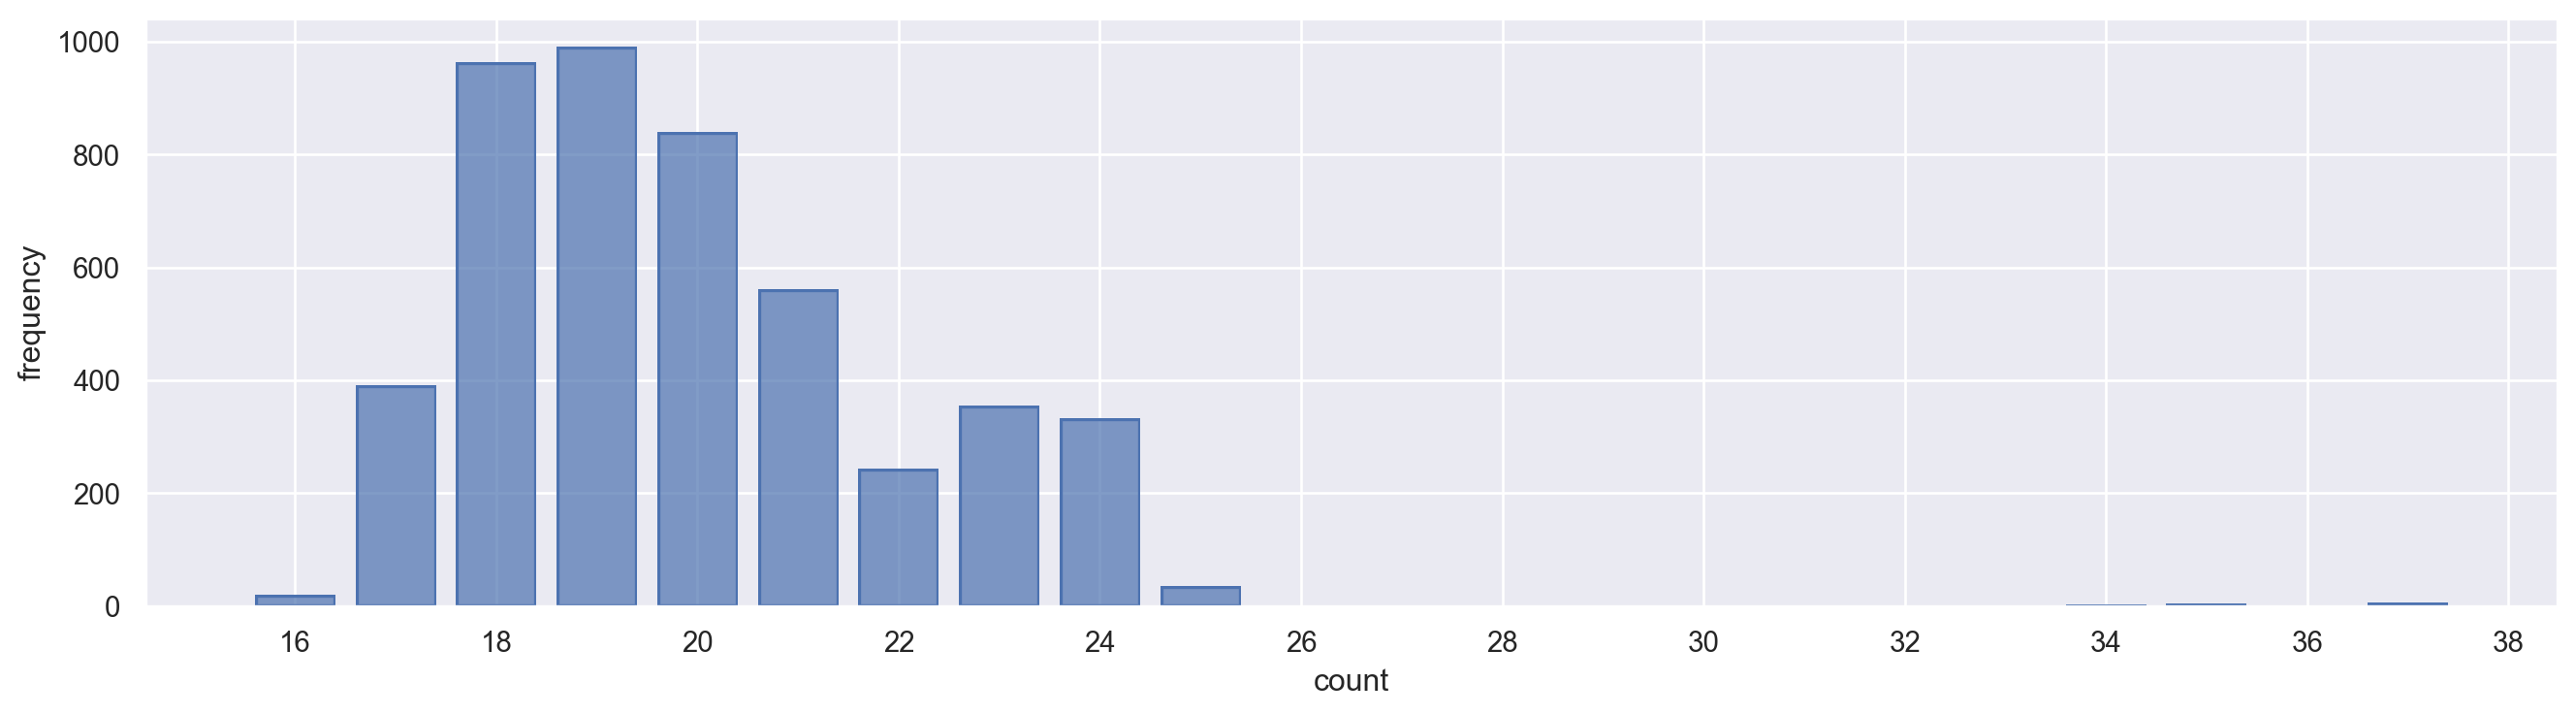

In [7]:
sns.set(rc={'figure.figsize':(18.7,18.27)})

temporal_samples_count = df_positive.groupby(['hex'])['hex'].count()

hist = pd.DataFrame(temporal_samples_count) \
        .rename(columns={'hex': 'count'}) \
        .reset_index(level=0) \
        .groupby(['count'])['count'].count()

hist_df = pd.DataFrame(hist) \
          .rename(columns={'count': 'frequency'}) \
          .reset_index(level=0)

so.Plot(hist_df["count"], hist_df["frequency"]) \
    .add(so.Bar()) \
    .scale(x=so.Continuous().tick(every=2)) \
    .layout(size=(14, 4))

## Sentinel 2 bands
These are the 12 bands contained in the parque files and their respective meanings

<div>
<img src="../res/sentinel2-bands.png" width="500"/>
</div>

## Show some of the L12 hexes loaded in the folium map

In [8]:
if True:
    # Drop hexes in non conclusive mixed areas
    drop_list = np.loadtxt('drop_list.csv', delimiter=',', dtype='str')

    df_negative = df_negative[~df_negative['hex'].isin(drop_list)]
    df_positive = df_positive[~df_positive['hex'].isin(drop_list)]

    # Treat false negatives
    false_negatives = np.loadtxt('false_negatives.csv', delimiter=',', dtype='str')

    df_negative = df_negative.assign(label=0)
    df_positive = df_positive.assign(label=1)

    print(sum(df_negative.label==1), sum(df_negative.label==0))
    
    df_negative = df_negative.reset_index()
    df_positive = df_positive.reset_index()
    # Assign to negatives recognized as false the label 1
    df_negative.loc[df_negative['hex'].isin(false_negatives), 'label'] = 1
    
    print(sum(df_negative.label==1), sum(df_negative.label==0))

    df_positive = pd.concat([df_positive, df_negative[df_negative.label==1]])
    
    df_negative = df_negative.drop(df_negative[df_negative.label == 1].index)

0 56562
16080 40482


In [9]:
if False:
    false_negatives = np.loadtxt('falsenegatives.csv', delimiter=',', dtype='str')

    df_negative = df_negative.assign(label=0)
    df_positive = df_positive.assign(label=1)

    print(sum(df_negative.label==1), sum(df_negative.label==0))

    df_negative.loc[df_negative['hex'].isin(false_negatives), 'label'] = 1

    print(sum(df_negative.label==1), sum(df_negative.label==0))
    
    
    df_positive = pd.concat([df_positive, df_negative[df_negative.label==1]])
    df_negative = df_negative.drop(df_negative[df_negative.label == 1].index)

In [10]:
h3_hex = h3.h3_to_parent(df_positive.iloc[0]['hex'], 3)

center = h3.h3_to_geo_boundary(h=h3_hex,geo_json=True)

df_positive_single_hex = df_positive.drop_duplicates(subset='hex', keep="first").head(500)
df_negative_single_hex = df_negative.drop_duplicates(subset='hex', keep="first").head(500)


m = folium.Map(location=(center[0][1], center[0][0]),
                tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr = 'Esri',
                name = 'Esri Satellite',
                zoom_start=17,
                overlay = False,
                control = True)

# Print h3 hex
geometry = { "type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=h3_hex,geo_json=True)]}
geo_j = folium.GeoJson(data=geometry, style_function=lambda x: {'fillColor': 'white', 'color': 'white', 'weight': 0.5})
geo_j.add_to(m)

# Print positive samples
for index, row in df_positive_single_hex.iterrows():
    geometry = { "type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=row['hex'],geo_json=True)]}
    geo_j = folium.GeoJson(data=geometry, style_function=lambda x: {'fillColor': 'yellow', 'color': 'green', 'weight': 0.5})
    folium.Popup(str(row['hex'])).add_to(geo_j)
    geo_j.add_to(m)
    
# Print negative samples
for index, row in df_negative_single_hex.iterrows():
    geometry = { "type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=row['hex'],geo_json=True)]}
    geo_j = folium.GeoJson(data=geometry, style_function=lambda x: {'fillColor': 'red', 'color': 'black', 'weight': 0.5})
    folium.Popup(str(row['hex'])).add_to(geo_j)
    geo_j.add_to(m)

m

# Visualize the samples in the space reduced to 2 dimensions

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

number_of_bands = len(band_features)

# Keep only [temporal samples] samples 
df_positive = df_positive.sort_values(by=['hex'])
df_positive = df_positive.groupby('hex').head(temporal_samples)

df_negative = df_negative.sort_values(by=['hex'])
df_negative = df_negative.groupby('hex').head(temporal_samples)

# Associate labels picked manually
df_negative = df_negative.assign(label=0)
df_positive = df_positive.assign(label=1)
df = pd.concat([df_positive, df_negative], axis=0)

df[band_features] = StandardScaler().fit_transform(df[band_features])

display(df.head(5))

# Organize the 2D samples in numpy arrays
sample = np.zeros((temporal_samples, number_of_bands), dtype=np.float64)
X_array = np.empty((0, temporal_samples, number_of_bands),  dtype=np.float64)

labels = []
hexes = []
timestamp_tracking = []
timestamp_sample = []

sub_index = 0
for index, row in df.iterrows():
        # fill the band values in a temporal row
        for idx,b in enumerate(band_features):
            sample[sub_index][idx] = row[b]

        timestamp_sample.append(row.timestamp)
         
        # increment row number 
        sub_index = sub_index + 1
        
        # if reached last row of temporal samples, increment to next sample
        if sub_index == temporal_samples:
            #np.random.shuffle(sample)

            shuffler = np.random.permutation(sample.shape[0])
            sample = sample[shuffler]
            timestamp_sample = list(np.array(timestamp_sample)[shuffler])

            if len(timestamp_sample) != temporal_samples:
                print('Invalid sample!')

            X_array = np.append(X_array, [sample], axis=0)

            labels.append(row.label)
            hexes.append(row.hex)
            timestamp_tracking.append(timestamp_sample.copy())            
            timestamp_sample.clear()
            sub_index = 0

print(X_array.shape)
print(len(labels))
print(len(hexes))

if(False):
    model = TSNE(n_components=2, perplexity=4, random_state=0)
    tsne_data = model.fit_transform(X_array.reshape(X_array.shape[0], number_of_bands * temporal_samples))
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2"))
    tsne_data = pd.concat([tsne_df, pd.DataFrame(labels, columns=['y'])], axis=1)
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "y"))

    sns.jointplot(data=tsne_df, x="Dim_1", y="Dim_2", hue='y')
    plt.show()
    warnings.filterwarnings('default')

index                 start_date                   end_date  \
0          5  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
82087    176  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
42886    178  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
5716       5  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   
28488      5  2018-10-27T00:00:00+00:00  2019-08-13T00:00:00+00:00   

                                  FIELD_OPERATION_GUID  \
0      1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
82087  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
42886  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
5716   1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   
28488  1107dbf9-a4d7-40cc-8899-27461e584ce2 2019-02-24   

                                                scene_id              hex  \
0      S2A_MSIL2A_20181029T170421_N0001_R069_T14RPQ_2...  8c48b3c444c33ff   
82087  S2B_MSIL2A_20190810T165849_N0213_R069_T14RPQ_2...  8c48b3c444c33ff   
42886  S2B_MSIL2A_20181213T170709_N0211_R069_T14RPQ_2...  8c48b3c444c33ff   
5716   S2A_MSIL2A_20190127T170551_N0211_R069_T14RPQ_2...  8c48b3c444c33ff   
28488  S2A_MSIL2A_20190616T165901_N0212_R069_T14RPQ_2...  8c48b3c444c33ff   

       SCL_val s2_tile       B01       B02  ...       B05       B06       B07  \
0            4   14RPQ -0.600640 -0.711229  ...  0.095625  1.086489  0.872762   
82087        5   14RPQ  2.111698  0.064990  ... -0.352497 -0.828154 -0.601927   
42886        5   14RPQ -0.916350 -0.925875  ... -0.970471 -1.491352 -1.369777   
5716         5   14RPQ -0.197361 -0.633857  ... -0.775321 -1.321010 -1.268675   
28488        4   14RPQ -0.411675 -0.366797  ...  0.563624  0.542530  0.466613   

            B08       B8A       B09       B11       B12        timestamp  \
0      0.872822  0.814010  0.547688 -0.196589 -0.552988  20181029T170421   
82087 -0.989958 -0.328169 -0.078247 -0.613570  0.175597  20190810T165849   
42886 -1.366800 -1.359325 -1.275895 -0.684735 -0.322172  20181213T170709   
5716  -1.204276 -1.228118 -1.114029 -0.585771 -0.498199  20190127T170551   
28488  0.572777  0.522157 -0.221773  0.489484 -0.103014  20190616T165901   

       label  
0          1  
82087      1  
42886      1  
5716       1  
28488      1  

[5 rows x 22 columns]

(7115, 15, 12)
7115
7115


## Sample visualization

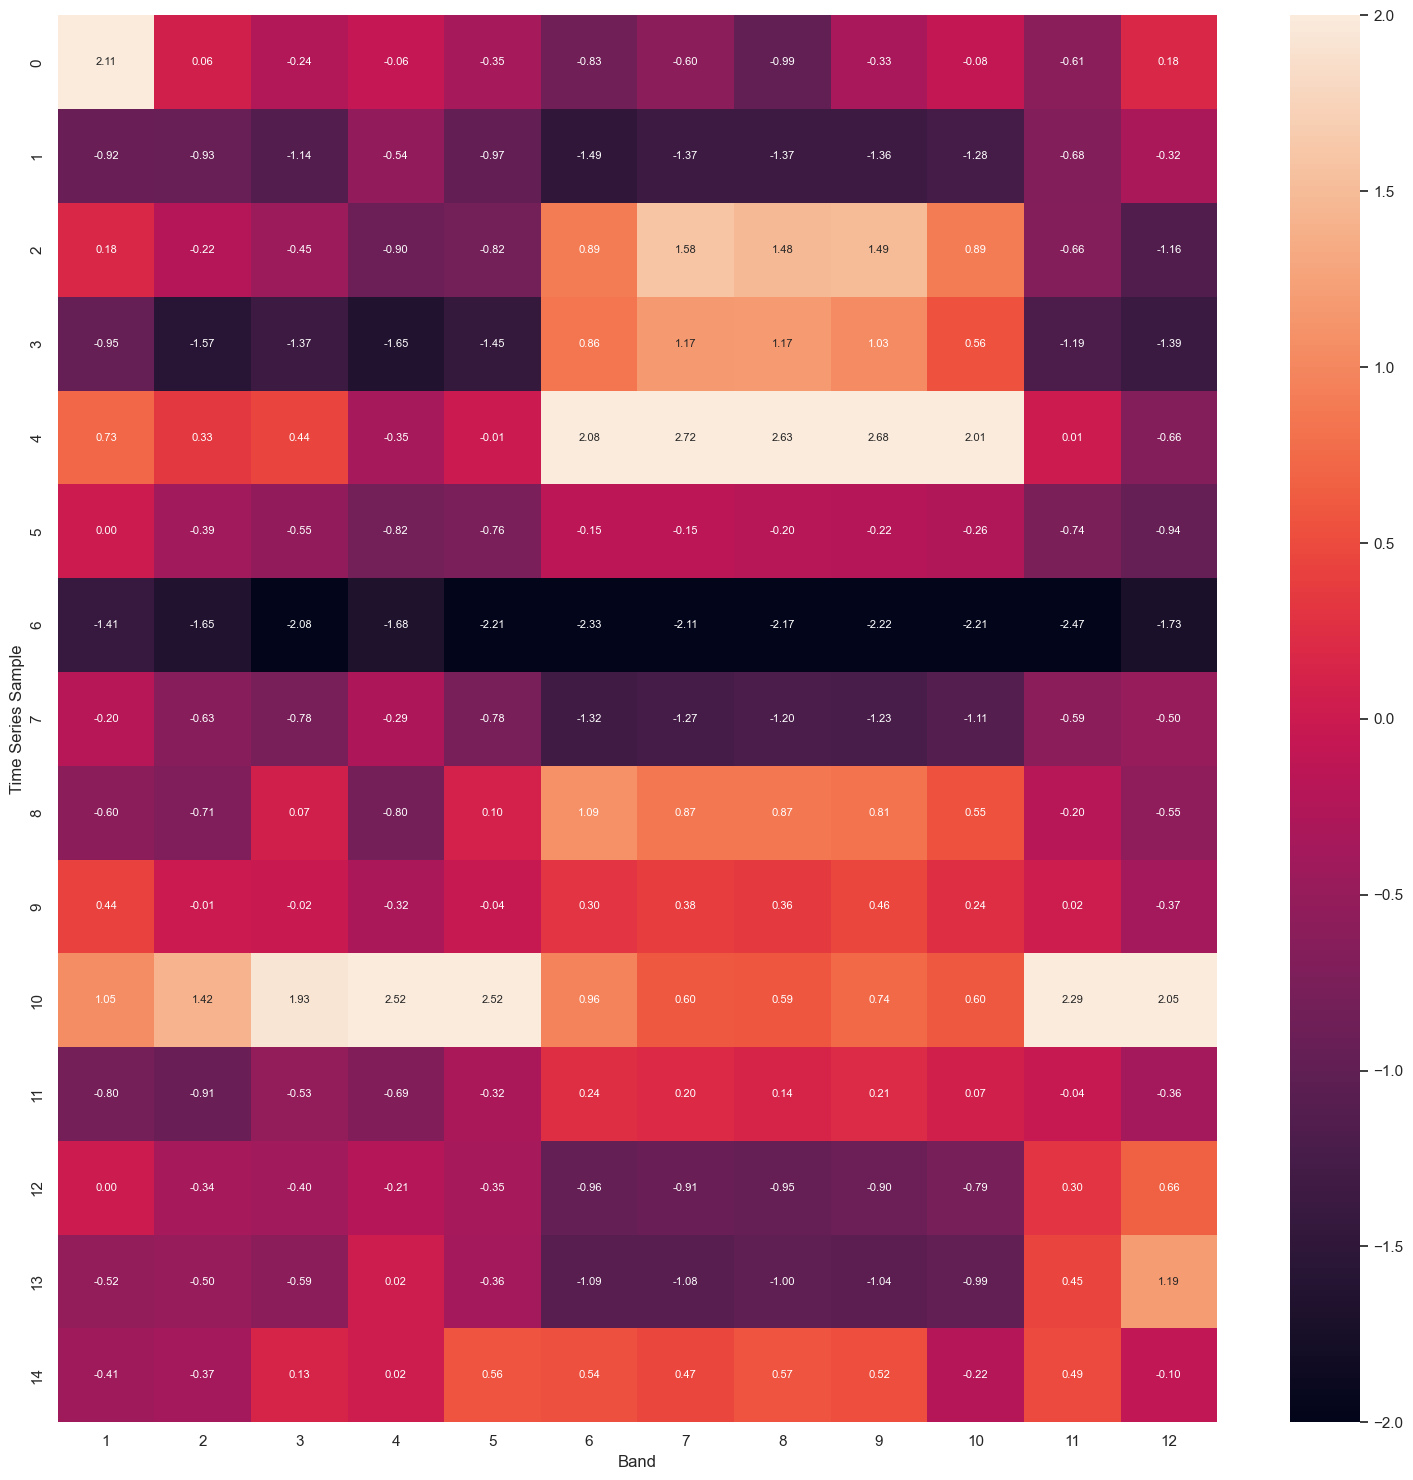

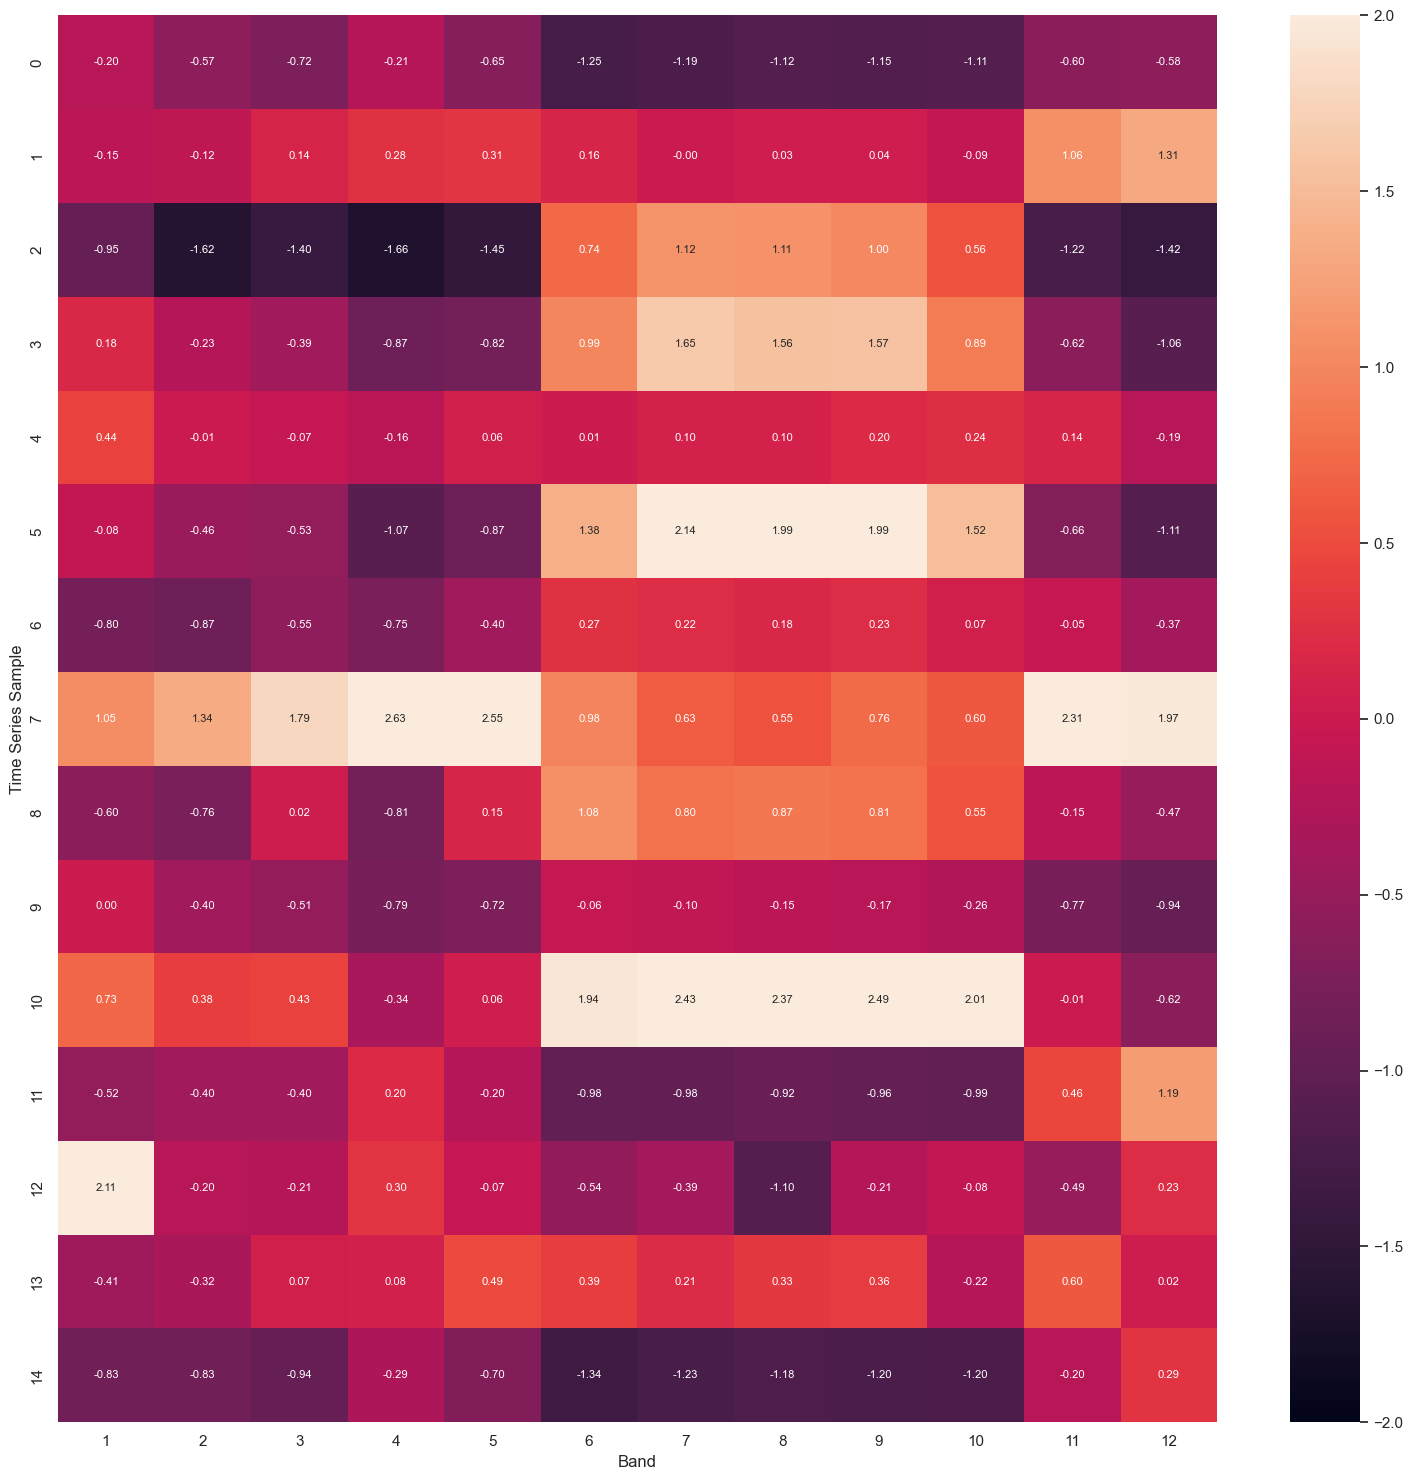

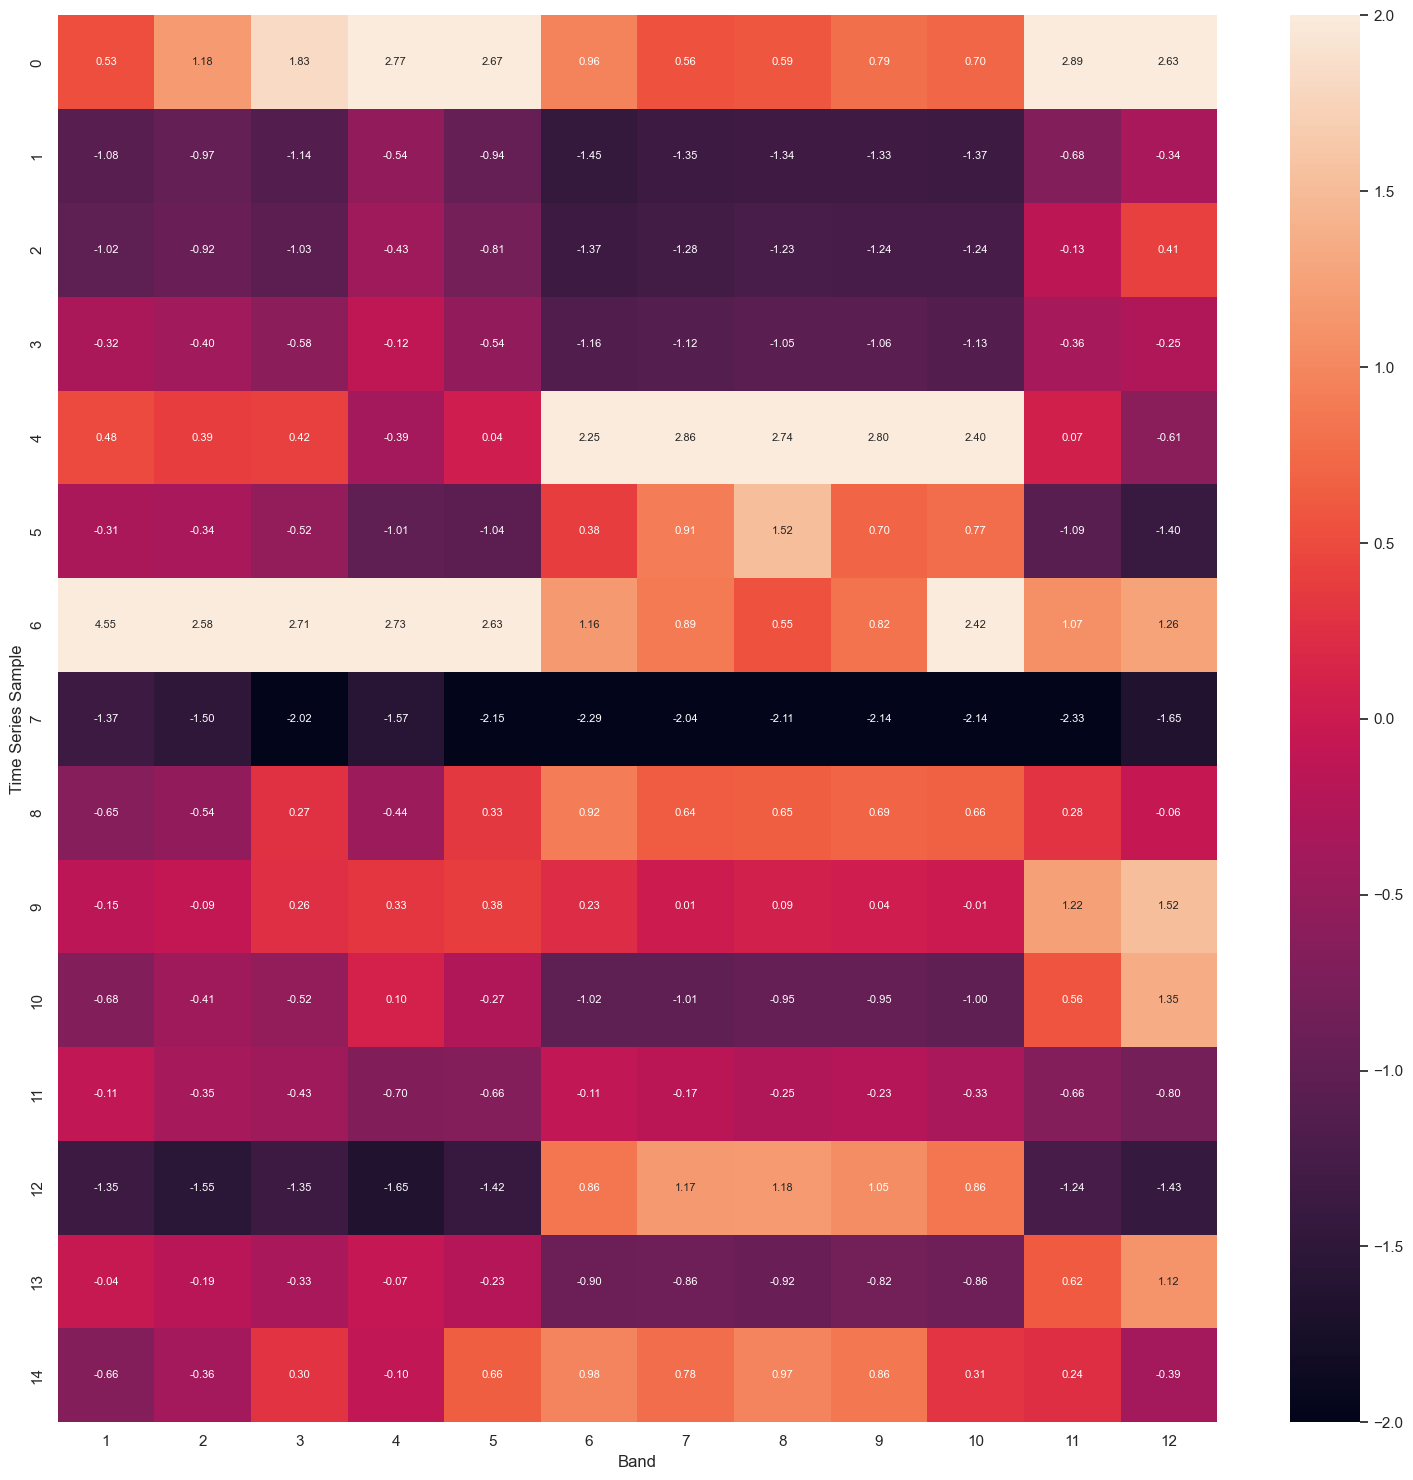

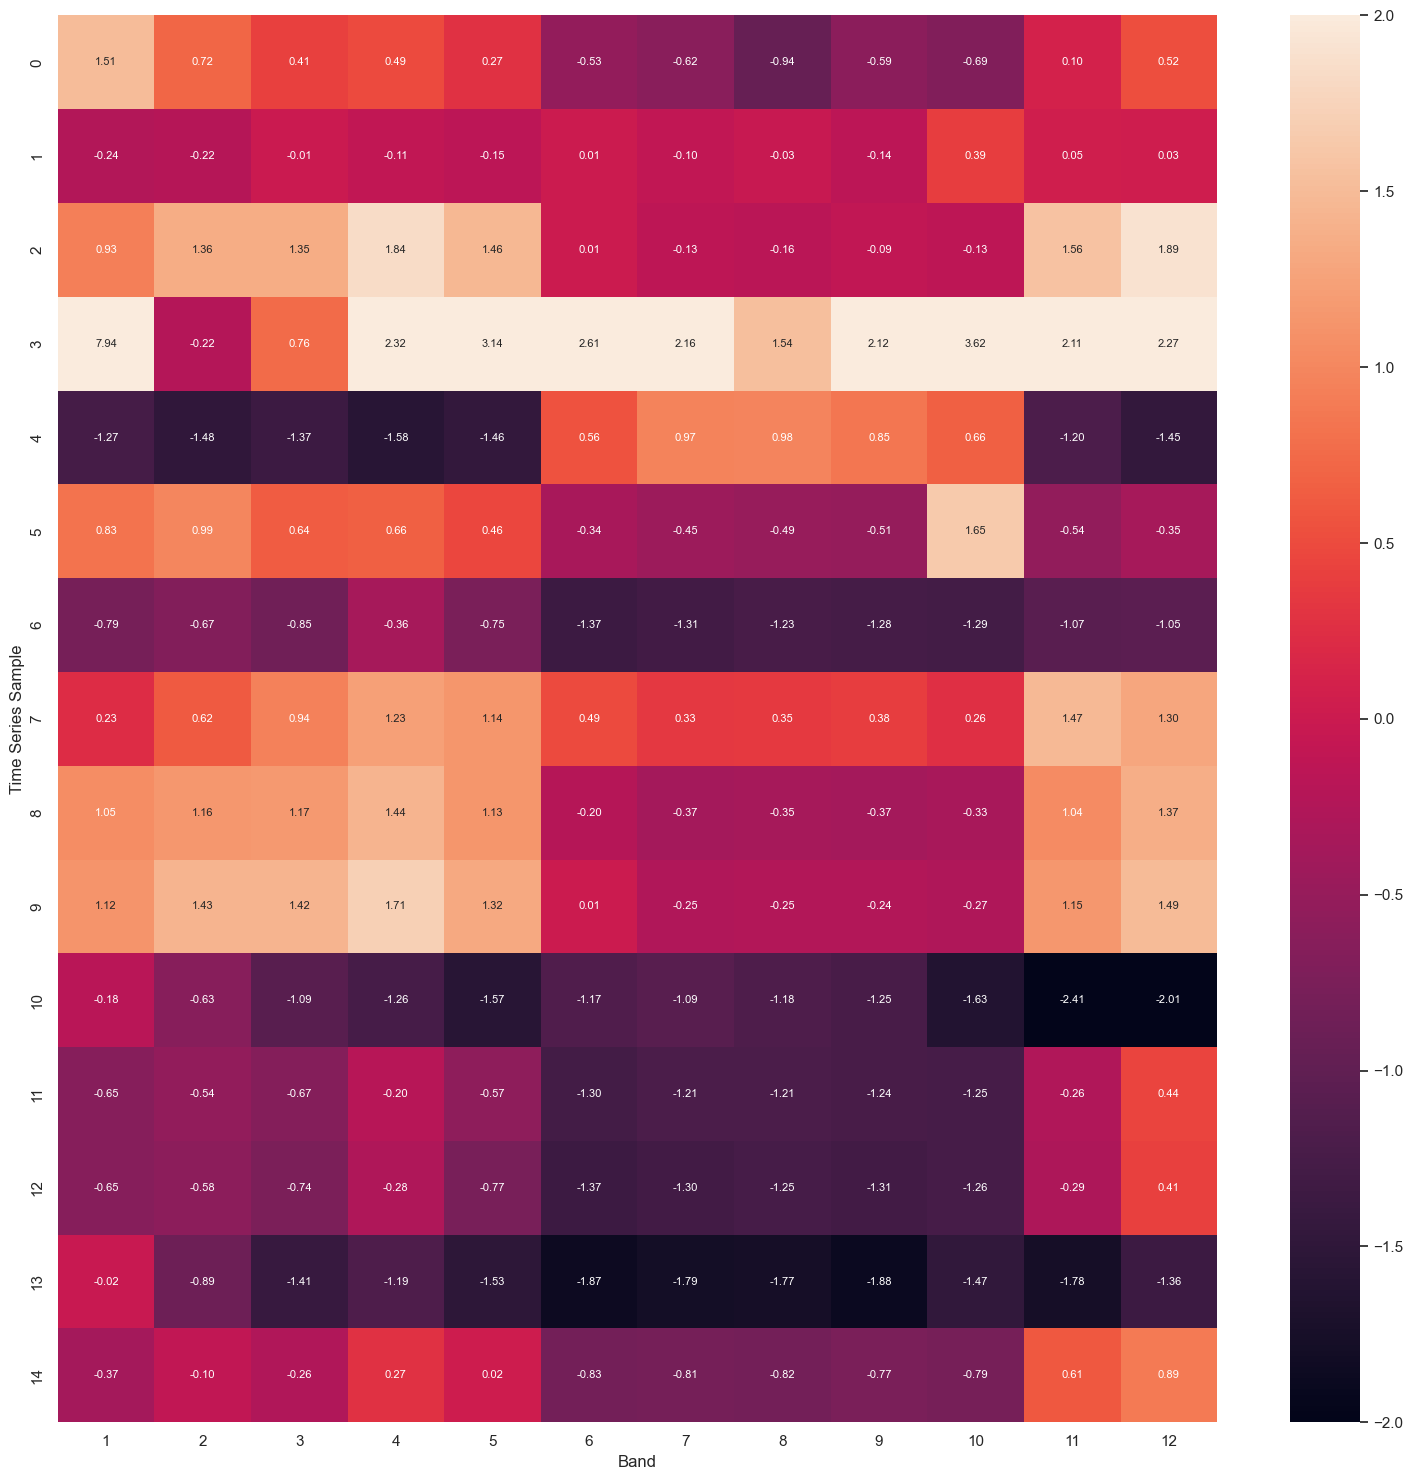

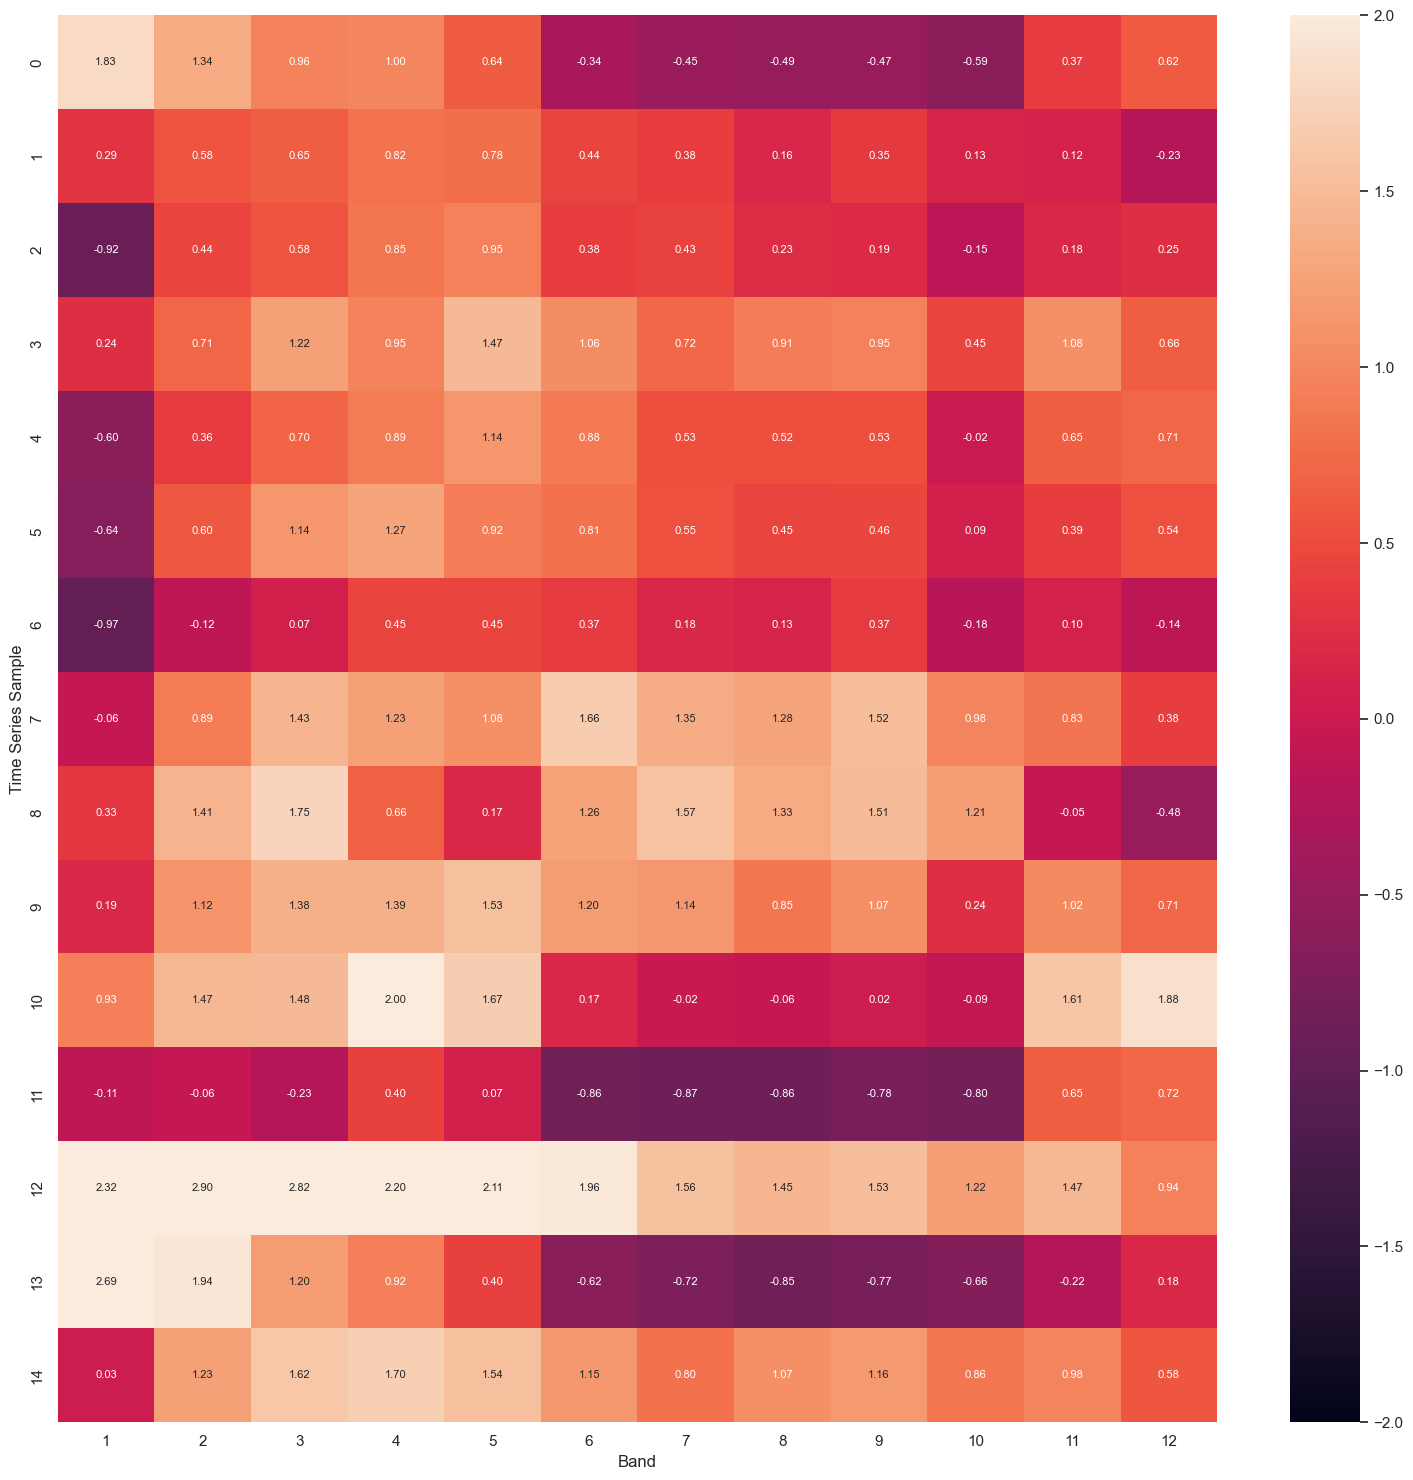

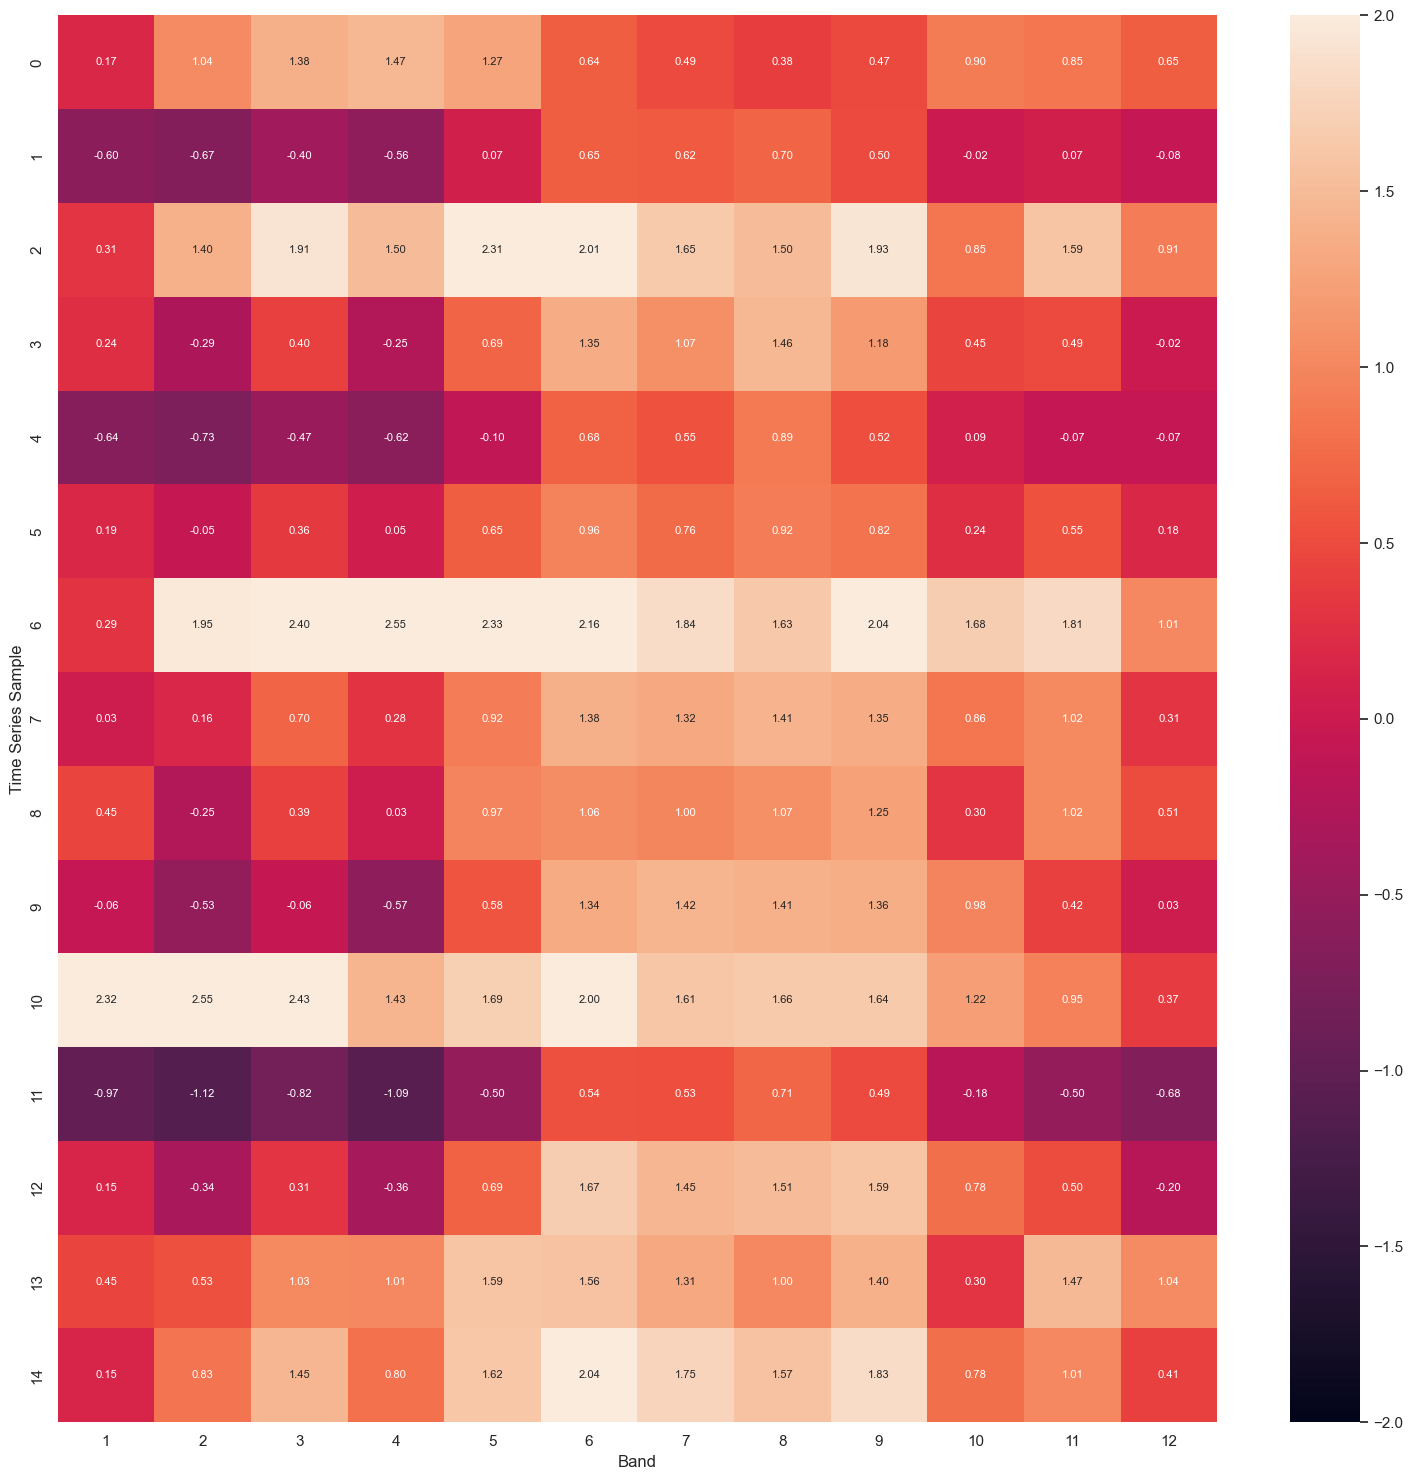

In [12]:
# This is what a positive sample looks like
ax = sns.heatmap(X_array[0], annot=True, vmin=-2, vmax=2, xticklabels=range(1,13), yticklabels='auto', fmt='.2f', annot_kws={"fontsize":8})
ax.set(xlabel="Band", ylabel="Time Series Sample")
plt.show()
ax = sns.heatmap(X_array[1], annot=True, vmin=-2, vmax=2, xticklabels=range(1,13), yticklabels='auto', fmt='.2f', annot_kws={"fontsize":8})
ax.set(xlabel="Band", ylabel="Time Series Sample")
plt.show()
ax = sns.heatmap(X_array[2], annot=True, vmin=-2, vmax=2, xticklabels=range(1,13), yticklabels='auto', fmt='.2f', annot_kws={"fontsize":8})
ax.set(xlabel="Band", ylabel="Time Series Sample")
plt.show()

ax = sns.heatmap(X_array[-1], annot=True, vmin=-2, vmax=2, xticklabels=range(1,13), yticklabels='auto', fmt='.2f', annot_kws={"fontsize":8})
ax.set(xlabel="Band", ylabel="Time Series Sample")
plt.show()
ax = sns.heatmap(X_array[-2], annot=True, vmin=-2, vmax=2, xticklabels=range(1,13), yticklabels='auto', fmt='.2f', annot_kws={"fontsize":8})
ax.set(xlabel="Band", ylabel="Time Series Sample")
plt.show()
ax = sns.heatmap(X_array[-3], annot=True, vmin=-2, vmax=2, xticklabels=range(1,13), yticklabels='auto', fmt='.2f', annot_kws={"fontsize":8})
ax.set(xlabel="Band", ylabel="Time Series Sample")
plt.show()

<AxesSubplot:xlabel='variable', ylabel='value'>

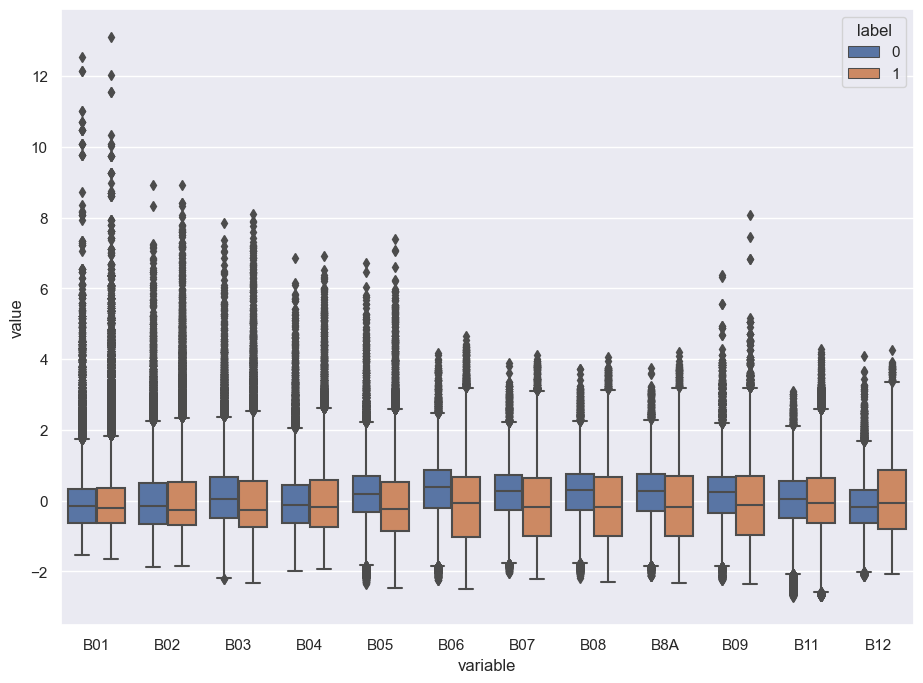

In [13]:
import pandas as pd
import seaborn as sns


value_vars = [i for i in df.columns if i.startswith('B')]
id_vars = ['label']
data = pd.melt(df, id_vars=id_vars, value_vars=value_vars)

sns.set(rc={'figure.figsize':(11,8)})
sns.boxplot(x="variable", y="value", hue='label', data=data)

# Check correlation among bands

<AxesSubplot:>

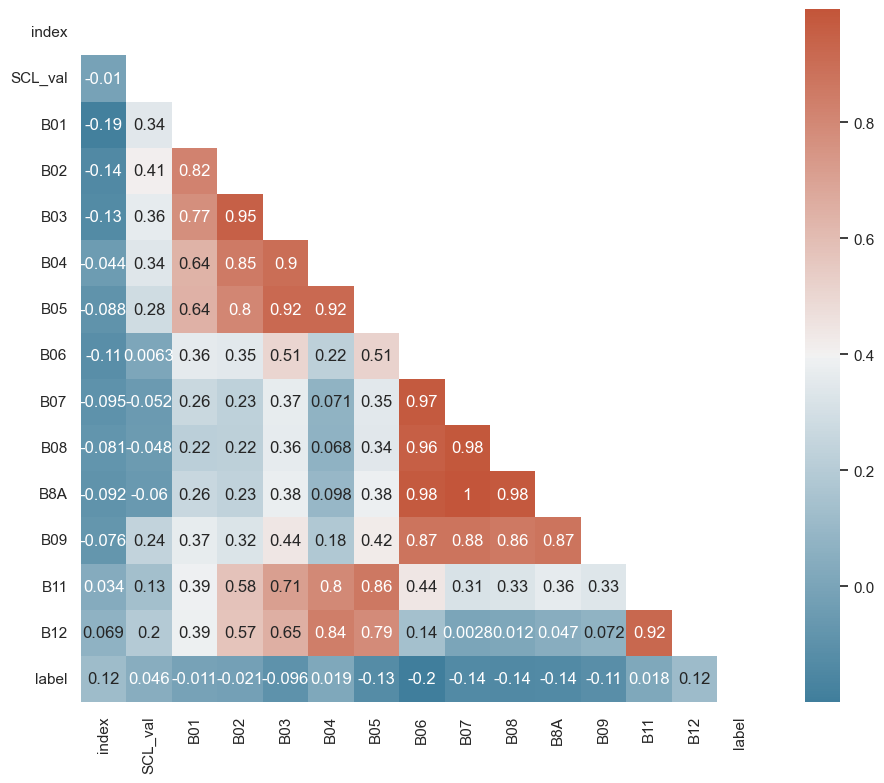

In [14]:
sns.set_theme(style="white")
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#            square=True, linewidths=.5, cbar_kws={"shrink": .5})

sns.heatmap(corr,mask=mask,cmap=cmap, annot=True )

In [15]:
print(X_array.shape)

(7115, 15, 12)


<AxesSubplot:>

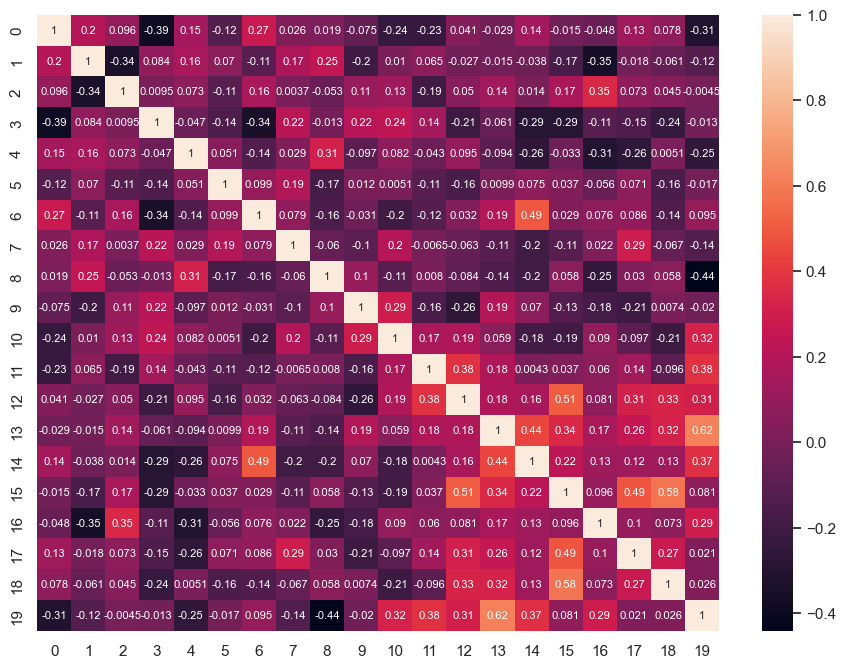

In [16]:
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

number_of_hexes = 10

X_array_positive = X_array[np.array(labels)==1][:number_of_hexes]
X_array_negative = X_array[np.array(labels)==0][:number_of_hexes]
X_array_samples = np.concatenate([X_array_positive, X_array_negative])

similarities = cosine_similarity(X_array_samples.reshape(number_of_hexes * 2, number_of_bands * temporal_samples), X_array_samples.reshape(number_of_hexes * 2,number_of_bands * temporal_samples))

sns.heatmap(similarities, annot=True, annot_kws={"fontsize":8})  

## Prepare the Dataset

In [17]:
X_array_n = X_array[np.array(labels) == 0]
X_array_p = X_array[np.array(labels) == 1]

In [18]:
from sklearn.model_selection import train_test_split

print('Total of samples:', X_array.shape)

labels_and_hexes = np.vstack((hexes, labels)).T

X_array_anchors = X_array_p[0:math.floor((X_array_p.shape[0]/2))]
X_array_positives = X_array_p[math.floor(X_array_p.shape[0]/2):-1]
X_array_negatives = X_array_n[0:math.floor((X_array_p.shape[0]/2))]

print('Total of anchors samples:', X_array_anchors.shape)
print('Total of positive samples:', X_array_positives.shape)
print('Total of negative samples:', X_array_negatives.shape)

samples_count = X_array_anchors.shape[0]
print('Number of samples:', samples_count)

Total of samples: (7115, 15, 12)
Total of anchors samples: (2533, 15, 12)
Total of positive samples: (2532, 15, 12)
Total of negative samples: (2049, 15, 12)
Number of samples: 2533


In [19]:
def prepare_dataset():
    anchor_dataset = tf.data.Dataset\
        .from_tensor_slices(X_array_anchors)

    positive_dataset = tf.data.Dataset\
        .from_tensor_slices(X_array_positives)
    
    negative_dataset = tf.data.Dataset\
        .from_tensor_slices(X_array_negatives)
    
    return anchor_dataset, positive_dataset, negative_dataset
   
anchor_dataset, positive_dataset, negative_dataset = prepare_dataset()
print(anchor_dataset, positive_dataset, negative_dataset)


dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=128)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(samples_count * 0.8))
val_dataset = dataset.skip(round(samples_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
#train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
#val_dataset = val_dataset.prefetch(8)

print(train_dataset)
print(val_dataset)

<TensorSliceDataset shapes: (15, 12), types: tf.float64> <TensorSliceDataset shapes: (15, 12), types: tf.float64> <TensorSliceDataset shapes: (15, 12), types: tf.float64>
<BatchDataset shapes: ((None, 15, 12), (None, 15, 12), (None, 15, 12)), types: (tf.float64, tf.float64, tf.float64)>
<BatchDataset shapes: ((None, 15, 12), (None, 15, 12), (None, 15, 12)), types: (tf.float64, tf.float64, tf.float64)>


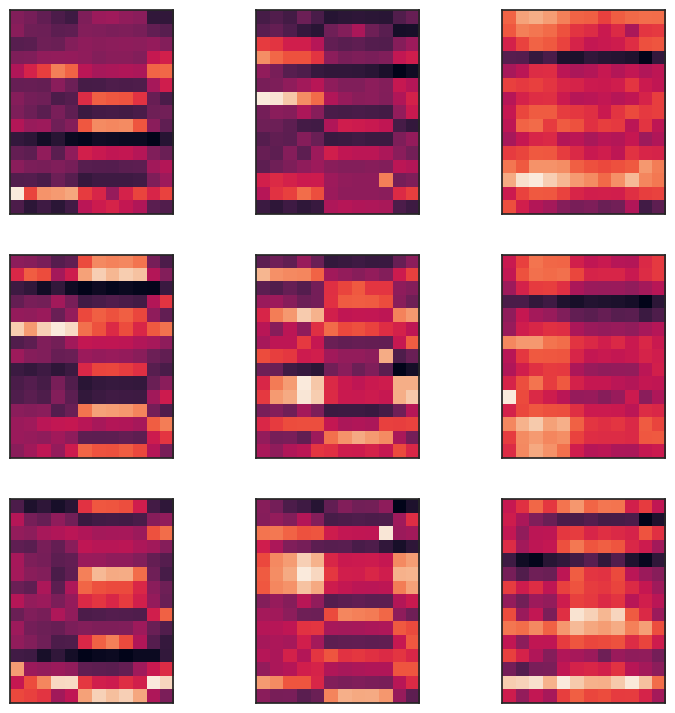

In [20]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [21]:
# Define the encoder architecture
def get_encoder():
    return keras.Sequential(
        [
            keras.Input(shape=(temporal_samples, number_of_bands)),
            layers.Conv1D(width, kernel_size=3, strides=1, activation="relu"),
            layers.Conv1D(width, kernel_size=3, strides=1, activation="relu"),
            layers.Conv1D(width, kernel_size=3, strides=1, activation="relu"),
            layers.Conv1D(width, kernel_size=3, strides=1, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )

embedding = get_encoder()

In [22]:
from tensorflow.keras import Model

class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=(15,12))
positive_input = layers.Input(name="positive", shape=(15,12))
negative_input = layers.Input(name="negative", shape=(15,12))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [23]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [24]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=keras.optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=50, validation_data=val_dataset)

Epoch 1/50
64/64 [==============================] - 1s 6ms/step - loss: 0.4171 - val_loss: 0.1355
Epoch 2/50
64/64 [==============================] - 0s 4ms/step - loss: 0.2248 - val_loss: 0.1259
Epoch 3/50
64/64 [==============================] - 0s 4ms/step - loss: 0.1239 - val_loss: 0.0578
Epoch 4/50
64/64 [==============================] - 0s 4ms/step - loss: 0.0796 - val_loss: 0.0162
Epoch 5/50
64/64 [==============================] - 0s 4ms/step - loss: 0.0582 - val_loss: 0.0320
Epoch 6/50
64/64 [==============================] - 0s 4ms/step - loss: 0.0442 - val_loss: 0.0219
Epoch 7/50
64/64 [==============================] - 0s 3ms/step - loss: 0.0332 - val_loss: 0.0281
Epoch 8/50
64/64 [==============================] - 0s 4ms/step - loss: 0.0264 - val_loss: 0.0378
Epoch 9/50
64/64 [==============================] - 0s 4ms/step - loss: 0.0204 - val_loss: 0.0000e+00
Epoch 10/50
64/64 [==============================] - 0s 4ms/step - loss: 0.0148 - val_loss: 0.0000e+00
Epoch 11/50

In [25]:
sample = next(iter(train_dataset))

anchor, positive, negative = sample

anchor_embedding, positive_embedding, negative_embedding = (
    embedding(anchor),
    embedding(positive),
    embedding(negative),
)

cosine_similarity = keras.metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

posneg_similarity = cosine_similarity(positive_embedding, negative_embedding)
print("PosNeg similarity", posneg_similarity.numpy())

Positive similarity: 0.92005485
Negative similarity 0.80821735
PosNeg similarity 0.7784732


# Checking similarities of encoded vectors

<AxesSubplot:>

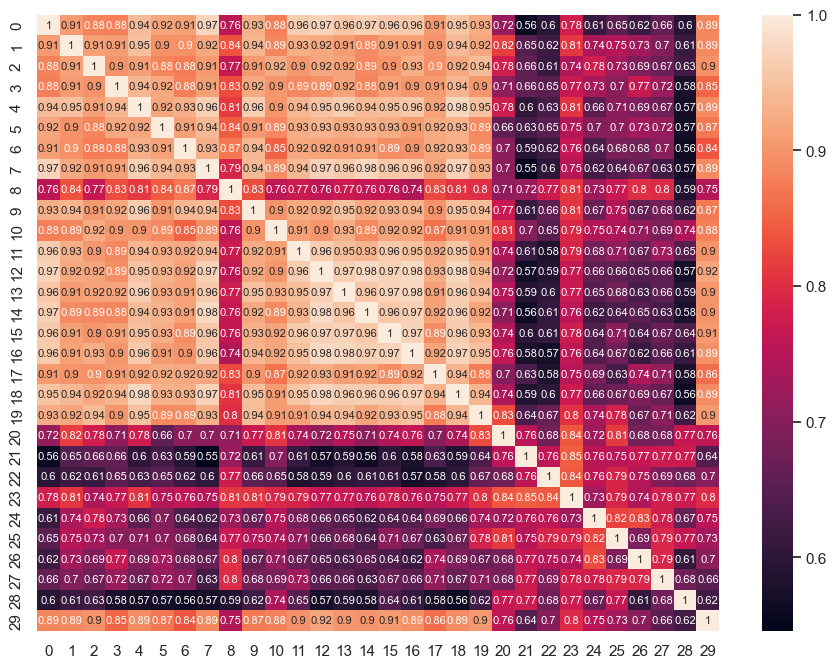

In [26]:
number_of_hexes= 10

subsample = np.concatenate([anchor_embedding[0:number_of_hexes],positive_embedding[0:number_of_hexes],negative_embedding[0:number_of_hexes]],0)
subsample_norm = tf.math.l2_normalize(subsample, axis=1)
similarities = tf.matmul(subsample_norm, subsample_norm, transpose_b=True)

sns.heatmap(similarities.numpy(), annot=True, annot_kws={"fontsize":8} )

# Finetuning model

In [27]:
from sklearn.model_selection import train_test_split

print('Total of samples:', X_array.shape)

labels_and_hexes = np.vstack((hexes, labels)).T

# 80% for training, 10% test and 10% validation
X_train, X_test, yl_train, yl_test = train_test_split(X_array, labels_and_hexes, test_size=0.2, random_state=42)
X_val, X_test, yl_val, yl_test = train_test_split(X_test, yl_test, test_size=0.5, random_state=42)

labeled_train_samples = X_train.shape[0]
hexes_train, y_train = np.hsplit(yl_train, 2)
hexes_test, y_test = np.hsplit(yl_test, 2)
hexes_val, y_val = np.hsplit(yl_val, 2)

y_val = np.array(y_val).T[0]
y_test = np.array(y_test).T[0]
y_train = np.array(y_train).T[0]
hexes_val = np.array(hexes_val).T[0]
hexes_test = np.array(hexes_test).T[0]
hexes_train = np.array(hexes_train).T[0]

y_train = y_train.astype(np.int)
y_test = y_test.astype(np.int)
y_val = y_val.astype(np.int)

print('Total of training samples:',X_train.shape, len(y_train))
print('Total of test samples:', X_test.shape, len(y_test))
print('Total of validation samples:', X_val.shape, len(y_val))



Total of samples: (7115, 15, 12)
Total of training samples: (5692, 15, 12) 5692
Total of test samples: (712, 15, 12) 712
Total of validation samples: (711, 15, 12) 711


In [28]:
# Clean test and validation datasets
if False:
    # Treat hexes in non conclusive areas
    drop_list = np.loadtxt('drop_list.csv', delimiter=',', dtype='str')
    
    drop_index = np.isin(hexes_val,drop_list)
    drop_index = [i for i, x in enumerate(drop_index) if x]
    X_val = np.delete(X_val, drop_index, axis=0)
    y_val = np.delete(y_val, drop_index, axis=0)
    hexes_val = np.delete(hexes_val, drop_index, axis=0)
    
    drop_index = np.isin(hexes_test,drop_list)
    drop_index = [i for i, x in enumerate(drop_index) if x]
    hexes_test = np.delete(hexes_test, drop_index, axis=0)
    X_test = np.delete(X_test, drop_index, axis=0)     
    y_test = np.delete(y_test, drop_index, axis=0)

    # Treat false negatives
    fn_list = np.loadtxt('false_negatives.csv', delimiter=',', dtype='str')
    
    fn_index = np.isin(hexes_val, fn_list)
    y_val[fn_index] = 1
    
    fn_index = np.isin(hexes_test, fn_list)
    y_test[fn_index] = 1
    
print(sum(np.array(y_train)==0),sum(np.array(y_train)==1))
print(sum(np.array(y_test)==0),sum(np.array(y_test)==1))
print(sum(np.array(y_val)==0),sum(np.array(y_val)==1))

1646 4046
190 522
213 498


In [29]:
def prepare_dataset():
    
    labeled_batch_size = labeled_train_samples
    batch_size = labeled_batch_size
 
    train_dataset = tf.data.Dataset\
        .from_tensor_slices((X_train, y_train))\
        .shuffle(buffer_size=10 * labeled_batch_size)\
        .batch(labeled_batch_size, drop_remainder=True)
    
    test_dataset = tf.data.Dataset\
        .from_tensor_slices((X_test, y_test))\
        .batch(batch_size)\
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    
    validation_dataset = tf.data.Dataset\
        .from_tensor_slices((X_val, y_val))\
        .batch(batch_size)\
        .prefetch(buffer_size=tf.data.AUTOTUNE)

    return batch_size, train_dataset, test_dataset, validation_dataset

batch_size, train_dataset, test_dataset, validation_dataset = prepare_dataset()

In [30]:
# Supervised finetuning of the pretrained encoder
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=(temporal_samples, number_of_bands)),
        get_encoder(),
        layers.Dense(1, activation='sigmoid'),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

print(train_dataset)
print(val_dataset)
finetuning_history = finetuning_model.fit(
    train_dataset, epochs=num_epochs * 10 , validation_data=validation_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)

<BatchDataset shapes: ((5692, 15, 12), (5692,)), types: (tf.float64, tf.int32)>
<BatchDataset shapes: ((None, 15, 12), (None, 15, 12), (None, 15, 12)), types: (tf.float64, tf.float64, tf.float64)>
Epoch 1/200
1/1 [==============================] - 1s 541ms/step - loss: 0.6611 - acc: 0.6757 - val_loss: 0.6030 - val_acc: 0.7004
Epoch 2/200
1/1 [==============================] - 0s 111ms/step - loss: 0.5983 - acc: 0.7108 - val_loss: 0.5827 - val_acc: 0.7004
Epoch 3/200
1/1 [==============================] - 0s 116ms/step - loss: 0.5720 - acc: 0.7108 - val_loss: 0.5874 - val_acc: 0.7004
Epoch 4/200
1/1 [==============================] - 0s 116ms/step - loss: 0.5740 - acc: 0.7108 - val_loss: 0.5697 - val_acc: 0.7004
Epoch 5/200
1/1 [==============================] - 0s 110ms/step - loss: 0.5580 - acc: 0.7108 - val_loss: 0.5451 - val_acc: 0.7004
Epoch 6/200
1/1 [==============================] - 0s 111ms/step - loss: 0.5363 - acc: 0.7108 - val_loss: 0.5280 - val_acc: 0.7004
Epoch 7/200
1/1 [

Epoch 123/200
1/1 [==============================] - 0s 109ms/step - loss: 0.0307 - acc: 0.9924 - val_loss: 0.0703 - val_acc: 0.9775
Epoch 124/200
1/1 [==============================] - 0s 120ms/step - loss: 0.0300 - acc: 0.9931 - val_loss: 0.0695 - val_acc: 0.9789
Epoch 125/200
1/1 [==============================] - 0s 117ms/step - loss: 0.0296 - acc: 0.9924 - val_loss: 0.0723 - val_acc: 0.9775
Epoch 126/200
1/1 [==============================] - 0s 111ms/step - loss: 0.0294 - acc: 0.9935 - val_loss: 0.0688 - val_acc: 0.9775
Epoch 127/200
1/1 [==============================] - 0s 122ms/step - loss: 0.0291 - acc: 0.9926 - val_loss: 0.0735 - val_acc: 0.9803
Epoch 128/200
1/1 [==============================] - 0s 98ms/step - loss: 0.0288 - acc: 0.9933 - val_loss: 0.0687 - val_acc: 0.9789
Epoch 129/200
1/1 [==============================] - 0s 111ms/step - loss: 0.0283 - acc: 0.9933 - val_loss: 0.0737 - val_acc: 0.9803
Epoch 130/200
1/1 [==============================] - 0s 113ms/step - l

In [31]:
from sklearn.metrics import accuracy_score, recall_score, precision_score,f1_score
from sklearn.metrics import confusion_matrix

print(
    "Finetuning maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)

print('---------------')

output = finetuning_model.predict(validation_dataset)
result = np.where(output > 0.5, 1, 0)

print('Triplet Loss Accuracy: {:.2f}%'.format(accuracy_score(y_val, result) * 100))
print('Triplet Loss Recall: {:.2f}%'.format(recall_score(y_val, result) * 100))
print('Triplet Loss Precision: {:.2f}%'.format(precision_score(y_val, result) * 100))
print('Triplet Loss F1: {:.2f}%'.format(f1_score(y_val, result) * 100))
m = confusion_matrix(y_val, result)
print('Triplet Loss Acc by Class', (m.diagonal()/m.sum(axis=1)))
print(confusion_matrix(y_val, result))
confusion_matrix(y_val, result)
accuracy_list = (y_val==result.T[0])

Finetuning maximal validation accuracy: 98.31%
---------------
Triplet Loss Accuracy: 98.03%
Triplet Loss Recall: 99.20%
Triplet Loss Precision: 98.02%
Triplet Loss F1: 98.60%
Triplet Loss Acc by Class [0.95305164 0.99196787]
[[203  10]
 [  4 494]]


In [32]:
df_classes = pd.DataFrame(result, columns=['label'])
df_hexes = pd.DataFrame(hexes_val, columns=['hex'])

df_predict = pd.concat([df_hexes,df_classes], axis=1)

center = h3.h3_to_geo_boundary(h=df_predict.iloc[0]['hex'],geo_json=True)

m = folium.Map(location=(center[0][1], center[0][0]),
                tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr = 'Esri',
                name = 'Esri Satellite',
                overlay = False,
                control = True)

for index, row in df_predict.iterrows():
    geometry = { "type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=row['hex'],geo_json=True)]}
    
    if row['label'] == 0:
        geo_j = folium.GeoJson(data=geometry, style_function=lambda x: {'fillColor': 'red', 'color': 'red', 'weight': 0.5})
    elif row['label'] == 1:
        geo_j = folium.GeoJson(data=geometry, style_function=lambda x: {'fillColor': 'green', 'color': 'green', 'weight': 0.5})  
    else:
        geo_j = folium.GeoJson(data=geometry, style_function=lambda x: {'fillColor': 'black', 'color': 'black', 'weight': 0.5})
    folium.Popup(str(row['hex'])).add_to(geo_j)
    geo_j.add_to(m)
    
m

# End of Notebook